# Important: I'm too lazy to create three notebooks, so I will divide this notebook into three parts

### Start by creating a new Notebook for this assignment.

In [1]:
import pandas as pd
import numpy as np

###### Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe


Note: There are different website scraping libraries and packages in Python. For scraping the above table, you can simply use pandas to read the table into a pandas dataframe.

Another way, which would help to learn for more complicated cases of web scraping is using the BeautifulSoup package. Here is the package's main documentation page: http://beautiful-soup-4.readthedocs.io/en/latest/

The package is so popular that there is a plethora of tutorials and examples on how to use it. Here is a very good Youtube video on how to use the BeautifulSoup package: https://www.youtube.com/watch?v=ng2o98k983k

Use pandas, or the BeautifulSoup package, or any other way you are comfortable with to transform the data in the table on the Wikipedia page into the above pandas dataframe.

# Download, scraping and formatting

In [2]:
from bs4 import BeautifulSoup as BS
import requests
import re
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
text = requests.get(url).text
data = BS(text, 'lxml')


In [3]:
#### To create the dataframe:
####  The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
df = pd.DataFrame(columns = ['Postalcode','Borough','Neighborhood'])

tables = data.find('table')
table = tables.find('tbody')

rows=table.findAll('tr')

# skip all meta symbols and line feeds between rows:
for i, row in enumerate(rows): 
    rows[i] = str(rows[i])          \
    .replace("\n</th></tr>","")     \
    .replace("\n</td></tr>","")     \
    .replace("<tr>\n<td>","")       \
    .replace("<tr>\n<th>","")       \
    .replace("</th>\n<th>",",")     \
    .replace("</td>\n<td>",",")
    rows[i] = re.sub(r"<a.*?>", "", rows[i])
    rows[i] = re.sub(r"<\/a.*?>", "", rows[i])
    rows[i] = rows[i].split(",")
    if i != 0:
        df=df.append({"Postalcode":rows[i][0], "Borough":rows[i][1], "Neighborhood":rows[i][2]},ignore_index=True)
        

df.head()

,Postalcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [4]:
####  Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
df = df[df["Borough"] != "Not assigned"]

####  More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
df = df.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()

####  If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.
#check if this happens: df[df.Neighborhood == "Not assigned"]
df.loc[df.Neighborhood == "Not assigned", 'Neighborhood'] = df.Borough

####  Clean your Notebook and add Markdown cells to explain your work and any assumptions you are making.
#Done

####  In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.
print(df.shape)

(103, 3)


# Adding Geo-spatial Data

### Now that you have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

In [5]:
#import geocoder -> ModuleNotFoundError: No module named 'geocoder'

df_coor= pd.read_csv("http://cocl.us/Geospatial_data")
df=pd.merge(df, df_coor, left_on='Postalcode',right_on='Postal Code', how='left')
df.drop(columns = ["Postal Code"], inplace=True)

In [6]:
df

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv...",43.688905,-79.554724
101,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437


# Data analysis
### Explore and cluster the neighborhoods in Toronto. You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data. It is up to you.


In [7]:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library


Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\i1B259859\AppData\Local\Continuum\anaconda3

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1d             |       hfa6e2cd_0         4.7 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.7 MB

The following packages will be SUPERSEDED by a higher-priority channel:

  openssl              pkgs/main::openssl-1.1.1d-he774522_3 --> conda-forge::openssl-1.1.1d-hfa6e2cd_0




openssl-1.1.1d       | 4.7 MB    |            |   0% 
openssl-1.1.1d       | 4.7 MB    |            |   0% 
openssl-1.1.1d       | 4.7 MB    | 1          |   2% 
openssl-1.1.1d       | 4.7 MB    | 7          |   8% 
openssl-1.1.1d       | 4.7 MB    | #3         |  14% 
openssl-1.1.1d     

In [8]:
address = 'Toronto'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 43.653963, -79.387207.


In [9]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [10]:
!pip install --upgrade google-api-python-client oauth2client
!pip install ipython-secrets

Requirement already up-to-date: google-api-python-client in c:\users\i1b259859\appdata\local\continuum\anaconda3\lib\site-packages (1.7.11)
Requirement already up-to-date: oauth2client in c:\users\i1b259859\appdata\local\continuum\anaconda3\lib\site-packages (4.1.3)


In [11]:
import ipython_secrets
CLIENT_ID = ipython_secrets .get_secret('CLIENT_ID')
CLIENT_SECRET = ipython_secrets .get_secret('CLIENT_SECRET')
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + "LOL secret here")
print('CLIENT_SECRET:' + "LOL secret here")

Your credentails:
CLIENT_ID: LOL secret here
CLIENT_SECRET:LOL secret here


## Let's find the top places around toronto, to warm up

In [12]:


LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

In [13]:
results = requests.get(url).json()


In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
from pandas.io.json import json_normalize

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Japango,Sushi Restaurant,43.655268,-79.385165
2,Cafe Plenty,Café,43.654571,-79.389450
3,Sansotei Ramen 三草亭,Ramen Restaurant,43.655157,-79.386501
4,Rolltation,Japanese Restaurant,43.654918,-79.387424


In [16]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

80 venues were returned by Foursquare.


## Now we do the same for each element in the DF

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
df_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

## Let's hot-encode that

In [81]:
# one hot encoding
df_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_onehot['Neighborhood'] = df_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

df_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
df_grouped = df_onehot.groupby('Neighborhood').mean().reset_index()

In [83]:
num_top_venues = 5

for hood in df_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = df_grouped[df_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop  0.08
1                 Café  0.05
2                  Bar  0.04
3  American Restaurant  0.03
4     Sushi Restaurant  0.03


----Agincourt----
                       venue  freq
0  Latin American Restaurant   0.2
1             Breakfast Spot   0.2
2                     Lounge   0.2
3               Skating Rink   0.2
4             Clothing Store   0.2


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
                       venue  freq
0                 Playground  0.33
1                Coffee Shop  0.33
2                       Park  0.33
3  Middle Eastern Restaurant  0.00
4                      Motel  0.00


----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
                 venue  freq
0          Pizza Place  0.11
1  Japanese Restaurant  0.11
2             Pharmacy  0.11
3           Beer Store  0.11
4  Fried Chicken Join

                 venue  freq
0  Rental Car Location   0.5
1            Drugstore   0.5
2          Yoga Studio   0.0
3   Miscellaneous Shop   0.0
4  Monument / Landmark   0.0


----Northwood Park, York University----
                  venue  freq
0        Massage Studio   0.2
1    Falafel Restaurant   0.2
2  Caribbean Restaurant   0.2
3                   Bar   0.2
4           Coffee Shop   0.2


----Parkdale, Roncesvalles----
           venue  freq
0      Gift Shop  0.13
1    Coffee Shop  0.13
2      Bookstore  0.07
3   Dessert Shop  0.07
4  Movie Theater  0.07


----Parkwoods----
                             venue  freq
0                Food & Drink Shop   0.5
1                             Park   0.5
2                      Yoga Studio   0.0
3  Molecular Gastronomy Restaurant   0.0
4       Modern European Restaurant   0.0


----Queen's Park----
         venue  freq
0  Coffee Shop  0.26
1          Gym  0.05
2        Diner  0.05
3         Park  0.05
4  Yoga Studio  0.03


----Rosedale----

In [84]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [85]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = df_grouped['Neighborhood']

for ind in np.arange(df_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,American Restaurant,Restaurant,Bakery,Steakhouse,Sushi Restaurant,Asian Restaurant,Thai Restaurant
1,Agincourt,Lounge,Latin American Restaurant,Clothing Store,Skating Rink,Breakfast Spot,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Playground,Coffee Shop,Women's Store,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Pharmacy,Beer Store,Fried Chicken Joint,Japanese Restaurant,Fast Food Restaurant,Discount Store,Pizza Place,Sandwich Place,Grocery Store,Airport Terminal
4,"Alderwood, Long Branch",Pizza Place,Gym,Coffee Shop,Skating Rink,Pharmacy,Sandwich Place,Athletics & Sports,Pool,Pub,Discount Store


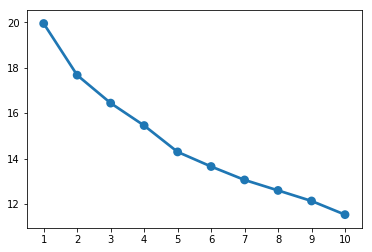

In [86]:
from sklearn.cluster import KMeans
import seaborn as sns

df_grouped_clustering = df_grouped.drop('Neighborhood', 1)
elbow_k = []

for kclusters in range (1, 11):
 
        # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
        kmeans_model = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)
 
        # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
        labels = kmeans_model.labels_
        
        # Sum of distances of samples to their closest cluster center
        interia = kmeans_model.inertia_
        elbow_k.append(interia)
    
sns.pointplot(list(range(1,11)),elbow_k, fit_reg=False)



### The possible K are 4 and 9

In [87]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(df_grouped_clustering)
# add clustering labels

neighborhoods_venues_sorted.insert(0, 'Cluster Labels 4', kmeans.labels_)
df_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
df_merged = df_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
df_merged.dropna(inplace=True)
df_merged["Cluster Labels 4"] = df_merged["Cluster Labels 4"].astype(int)
df_merged.head() # check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels 4,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,3,Fast Food Restaurant,Dessert Shop,Fabric Shop,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,0,Moving Target,Bar,Women's Store,Donut Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore,Dessert Shop
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0,Electronics Store,Mexican Restaurant,Pizza Place,Breakfast Spot,Rental Car Location,Intersection,Medical Center,Women's Store,Diner,Discount Store
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0,Coffee Shop,Korean Restaurant,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Women's Store
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0,Hakka Restaurant,Caribbean Restaurant,Athletics & Sports,Bakery,Bank,Thai Restaurant,Fried Chicken Joint,Dumpling Restaurant,Drugstore,Donut Shop


In [88]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood'], df_merged['Cluster Labels 4']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [89]:
kmeans = KMeans(n_clusters=9, random_state=0).fit(df_grouped_clustering)
# add clustering labels

neighborhoods_venues_sorted.insert(0, 'Cluster Labels 9', kmeans.labels_)
df_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
df_merged = df_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
df_merged.dropna(inplace=True)
df_merged["Cluster Labels 9"] = df_merged["Cluster Labels 9"].astype(int)
df_merged["Cluster Labels 4"] = df_merged["Cluster Labels 4"].astype(int)
df_merged.head() # check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels 9,Cluster Labels 4,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,0,3,Fast Food Restaurant,Dessert Shop,Fabric Shop,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1,0,Moving Target,Bar,Women's Store,Donut Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore,Dessert Shop
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1,0,Electronics Store,Mexican Restaurant,Pizza Place,Breakfast Spot,Rental Car Location,Intersection,Medical Center,Women's Store,Diner,Discount Store
3,M1G,Scarborough,Woburn,43.770992,-79.216917,7,0,Coffee Shop,Korean Restaurant,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Women's Store
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1,0,Hakka Restaurant,Caribbean Restaurant,Athletics & Sports,Bakery,Bank,Thai Restaurant,Fried Chicken Joint,Dumpling Restaurant,Drugstore,Donut Shop


In [90]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood'], df_merged['Cluster Labels 9']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Description of Cluster when Dividing in 9 groups

In [91]:
for i in range(0,9):
    print("_____________________________")
    print("Cluster: " + str(i+1))
    print()
    show = df_merged.loc[df_merged['Cluster Labels 9'] == i, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]
    cols = ["1st Most Common Venue","2nd Most Common Venue","3rd Most Common Venue","4th Most Common Venue","5th Most Common Venue"
           ,"6th Most Common Venue","7th Most Common Venue","8th Most Common Venue","9th Most Common Venue","10th Most Common Venue"]
    most_freqs=[]
    for col in cols:
        series = show[col]
        count = series.value_counts()
        count.index = count.index.map(str)
        one_elem = count[:1]
        sorted_elem = one_elem.sort_values(ascending=False)
        most_freq = sorted_elem.index[0]
        most_freqs.append(most_freq)
    print(most_freqs[:5])
    print(most_freqs[5:])
    
       



_____________________________
Cluster: 1

['Fast Food Restaurant', 'Dessert Shop', 'Fabric Shop', 'Event Space', 'Ethiopian Restaurant']
['Empanada Restaurant', 'Electronics Store', 'Eastern European Restaurant', 'Dumpling Restaurant', 'Drugstore']
_____________________________
Cluster: 2

['Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Sandwich Place']
['Discount Store', 'Discount Store', 'Dog Run', 'Doner Restaurant', 'Donut Shop']
_____________________________
Cluster: 3

['Playground', 'Playground', 'Drugstore', 'Dim Sum Restaurant', 'Diner']
['Discount Store', 'Dog Run', 'Doner Restaurant', 'Donut Shop', 'Dumpling Restaurant']
_____________________________
Cluster: 4

['Home Service', "Women's Store", 'Diner', 'Discount Store', 'Dog Run']
['Doner Restaurant', 'Donut Shop', 'Drugstore', 'Dumpling Restaurant', 'Dessert Shop']
_____________________________
Cluster: 5

['Park', "Women's Store", "Women's Store", 'Donut Shop', 'Dim Sum Restaurant']
['Diner', 'Discount Stor

# Description of Cluster when Dividing in 4 groups

In [92]:
for i in range(0,4):
    print("_____________________________")
    print("Cluster: " + str(i+1))
    print()
    show = df_merged.loc[df_merged['Cluster Labels 4'] == i, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]
    cols = ["1st Most Common Venue","2nd Most Common Venue","3rd Most Common Venue","4th Most Common Venue","5th Most Common Venue"
           ,"6th Most Common Venue","7th Most Common Venue","8th Most Common Venue","9th Most Common Venue","10th Most Common Venue"]
    most_freqs=[]
    for col in cols:
        series = show[col]
        count = series.value_counts()
        count.index = count.index.map(str)
        one_elem = count[:1]
        sorted_elem = one_elem.sort_values(ascending=False)
        most_freq = sorted_elem.index[0]
        most_freqs.append(most_freq)
    print(most_freqs[:5])
    print(most_freqs[5:])
    
       



_____________________________
Cluster: 1

['Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Coffee Shop', 'Diner']
['Discount Store', 'Discount Store', 'Dog Run', 'Doner Restaurant', 'Donut Shop']
_____________________________
Cluster: 2

['Park', "Women's Store", "Women's Store", 'Drugstore', 'Dim Sum Restaurant']
['Diner', 'Discount Store', 'Dog Run', 'Doner Restaurant', 'Donut Shop']
_____________________________
Cluster: 3

['Home Service', 'Construction & Landscaping', 'Baseball Field', 'Discount Store', 'Diner']
['Discount Store', 'Dog Run', 'Drugstore', 'Dumpling Restaurant', "Women's Store"]
_____________________________
Cluster: 4

['Fast Food Restaurant', 'Dessert Shop', 'Fabric Shop', 'Event Space', 'Ethiopian Restaurant']
['Empanada Restaurant', 'Electronics Store', 'Eastern European Restaurant', 'Dumpling Restaurant', 'Drugstore']


In [93]:
df_merged["Cluster Labels 4"].value_counts()

0    88
1     8
2     3
3     1
Name: Cluster Labels 4, dtype: int64

# Conclusion:
The fact that there is in both cases a single cluster really big and other clusters smaller, should make us think that Kmean is not the best algorithm for our purpose 